# 第九章 无监督学习技术

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 9.1 聚类

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Saving figure classification_vs_clustering_plot


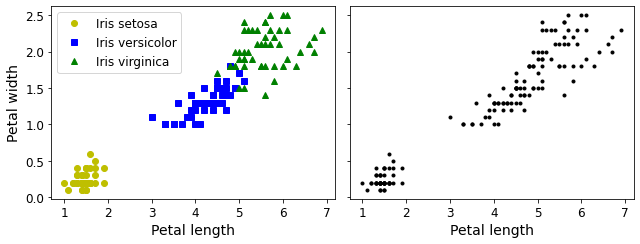

In [4]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

A Gaussian mixture model (explained below) can actually separate these clusters pretty well (using all 4 features: petal length & width, and sepal length & width).

In [5]:
from sklearn.mixture import GaussianMixture

In [6]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

Let's map each cluster to a class. Instead of hard coding the mapping (as is done in the book, for simplicity), we will pick the most common class for each cluster (using the `scipy.stats.mode()` function):

In [7]:
from scipy import stats

mapping = {}
for class_id in np.unique(y):
    mode, _ = stats.mode(y_pred[y==class_id])
    mapping[mode[0]] = class_id

mapping

{1: 0, 2: 1, 0: 2}

In [8]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

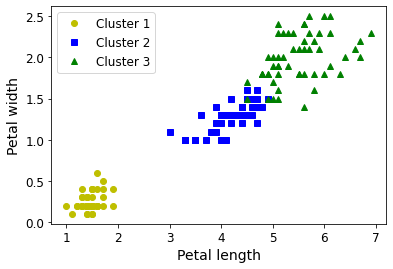

In [9]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [10]:
np.sum(y_pred==y)

145

In [11]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

**Note**: the results in this notebook may differ slightly from the book. This is because algorithms can sometimes be tweaked a bit between Scikit-Learn versions.

### 9.1.1 K-Means

Let's start by generating some blobs:

In [12]:
from sklearn.datasets import make_blobs

In [13]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [14]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [15]:
# Now let's plot them:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


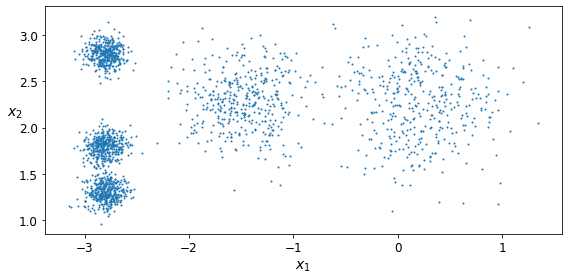

In [16]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [17]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the 5 clusters:

In [18]:
y_pred

array([4, 1, 0, ..., 3, 0, 1])

In [19]:
y_pred is kmeans.labels_

True

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [20]:
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [21]:
kmeans.labels_

array([4, 1, 0, ..., 3, 0, 1])

Of course, we can predict the labels of new instances:

In [22]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 3, 3])

Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [23]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


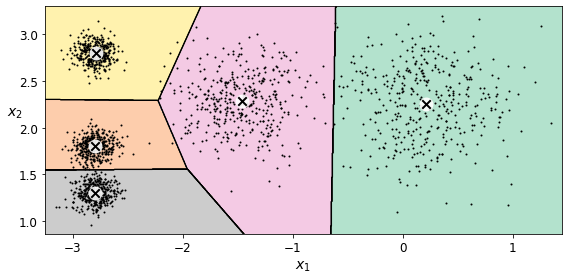

In [24]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good.